# larger datasets

In [2]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import zarr

from utils import remove_all_ticks_and_labels

# import MNIST dataset

In [9]:
# params
description = {
    'model_name': 'dendritic-mnist',
    'model_number': 20,
    'num_steps': 100,
    'forward_schedule': 'sigmoid',
    'batch_size': 256,
    'hidden_cfg': [12, 12],
    'num_ambient_dims': 28 * 28,
    'num_epochs': 200,
    'manifold_type': 'mnist',
    'lr': 3e-4,
    'optimizer': 'Adam',
    'classes': 'all',
}

# # params
# description = {
#     'model_name': 'fc-mnist',
#     'model_number': 9,
#     'num_hidden_layers': 5,
#     'num_steps': 100,
#     'forward_schedule': 'sine',
#     'batch_size': 256,
#     'hidden_cfg': 2048,
#     'num_ambient_dims': 28 * 28,
#     'num_epochs': 200,
#     'manifold_type': 'mnist',
#     'lr': 3e-4,
#     'optimizer': 'Adam',
#     'classes': 'all',
# }


pretrained = False
if pretrained:
    description['pretrained'] = True
    description['pretrained_model_name'] = 'dendritic-mnist'
    description['pretrained_model_num'] = 6
else:
    description['pretrained'] = False
    
# save description
# with open(os.path.join(base_dir, 'core', 'model_description', f'{description["model_name"]}_{description["model_number"]}.json'), 'w') as f:
#     json.dump(description, f)

In [38]:
import torch
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')

mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,))
                ]))

print(torch.min(mnist_train.data), torch.max(mnist_train.data))
print(mnist_train[0][0].min(), mnist_train[0][0].max())
from image_utils import rescale_to_neg_one_to_one
test = rescale_to_neg_one_to_one(mnist_train[0][0])
print(test.min(), test.max())

# ------------------------------- select digits ------------------------------ #
# indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2)
# mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(mnist_dir, train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args['test_batch_size'], shuffle=True, **kwargs)

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0.) tensor(1.)
tensor(-1.) tensor(1.)


torch.Size([100, 784])
torch.Size([78400])


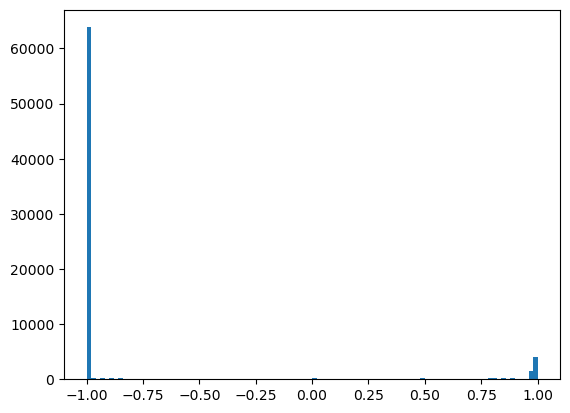

In [39]:
# how is the data distributed?
all_pixels = []
for i in range(100):
    all_pixels.append(mnist_train[i][0].squeeze().reshape(-1))
all_pixels = torch.stack(all_pixels)
print(all_pixels.shape)
all_pixels = rescale_to_neg_one_to_one(all_pixels)

all_pixels = all_pixels.reshape(-1)
print(all_pixels.shape)

fig, ax = plt.subplots(1, 1)
a = ax.hist(all_pixels, bins=100)

torch.Size([1, 28, 28])
torch.Size([28, 28])
tensor(-3.8540)
tensor(2.6133)
torch.Size([39200])


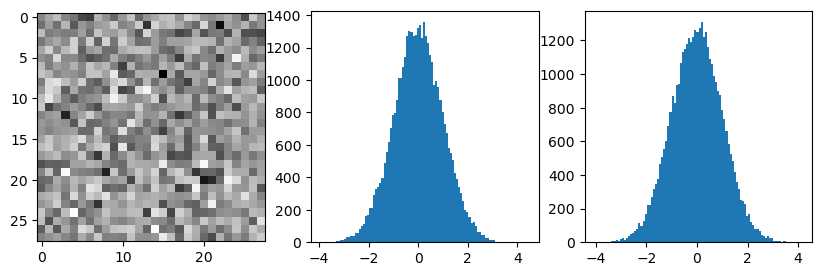

In [121]:
# forward process
from image_utils import generate_noisy_sample

num_steps = 100
t = 99
x_0 = mnist_train[0][0]
print(x_0.shape)
x_0s = []
for i in range(50):
    x_0s.append(mnist_train[i][0])
x_0s = torch.stack(x_0s)

schedule = 'sine'
start = 1e-5
end = 2e-1
x_noisy = generate_noisy_sample(num_steps, t, x_0, schedule, start, end)[0]

print(x_noisy.shape)
print(x_noisy.min())
print(x_noisy.max())

fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].imshow(x_noisy, cmap='gray')

# get distribution of pixels 
x_noisys = []
for i in range(50):
    x_noisys.append(generate_noisy_sample(num_steps, t, x_0s[i], schedule, start, end)[0])
x_noisys = torch.stack(x_noisys)
x_noisys = x_noisys.reshape(-1)
print(x_noisys.shape)
a = ax[1].hist(x_noisys, bins=100)

random_samples = torch.randn_like(x_noisys)
b = ax[2].hist(random_samples, bins=100)


In [11]:
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

from models import VariableDendriticCircuit, FullyConnectedNetwork
if description['model_name'] == 'dendritic-mnist':
    model = VariableDendriticCircuit(hidden_cfg=description['hidden_cfg'], 
                                    num_in=description['num_ambient_dims'], 
                                    num_out=description['num_ambient_dims'], 
                                    bias=True)
elif description['model_name'] == 'fc-mnist':
    model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'], num_hidden=description['hidden_cfg'], num_hidden_layers=description['num_hidden_layers'])
model = model.to(device)
if description['pretrained']==True:
    from utils import load_model_weights
    pretrained_model_name = description['pretrained_model_name']
    pretrained_model_num = description['pretrained_model_num']
    print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
    model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)


optimizer = optim.Adam(model.parameters(), lr=description['lr'])
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])


Using device: cuda


In [26]:
def train(num_epochs, model, train_loader, num_steps, optimizer, tb, device):
    from image_utils import calculate_loss
    
    for epoch in tqdm(range(1, int(num_epochs) + 1)):
        # start training    
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            
            # compute the loss
            loss = calculate_loss(model, data, n_steps=description['num_steps'], forward_schedule=description['forward_schedule'], norm='l2', device=device)
            
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
            
            # write to tensorboard
            tb.add_scalar('Loss', loss.item(), epoch+batch_idx)
        
    return model

In [27]:
run_dir = os.path.join(base_dir, 'demos/runs', f'{description["model_name"]}_{description["model_number"]}')
tb = SummaryWriter(run_dir, flush_secs=1)

start_time = time.time()

model.train()
model = train(description['num_epochs'], model, train_loader, description['num_steps'], optimizer, tb, device)

from utils import save_model_weights
save_model_weights(model, description['model_name'], description['model_number'])
tb.flush()

  0%|          | 0/400 [00:00<?, ?it/s]

model state dict saved in directory: /mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_weights/fc-mnist_8.pt


# load model

In [446]:
model_name = 'dendritic-mnist'
# model_name = 'fc-mnist'
model_num = 32

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{model_name}_{model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    description = json.load(f)
    
description

{'model_name': 'dendritic-mnist',
 'model_number': 32,
 'batch_size': 512,
 'lr': 0.0003,
 'num_epochs': 5000.0,
 'forward_schedule': 'sigmoid',
 'hidden_cfg': [12, 12],
 'num_steps': 150,
 'num_ambient_dims': 784,
 'manifold_type': 'mnist',
 'optimizer': 'Adam',
 'classes': 'all',
 'pretrained': True,
 'pretrained_model_name': 'dendritic-mnist',
 'pretrained_model_num': 31}

In [447]:
# load model weights
load_model = True

if load_model == True:
    from models import VariableDendriticCircuit, FullyConnectedNetwork
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}', flush=True)
    if description['model_name'] == 'fc-mnist':
        model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'], num_hidden=description['hidden_cfg'], num_hidden_layers=description['num_hidden_layers'])
    elif description['model_name'] == 'dendritic-mnist':
        model = VariableDendriticCircuit(hidden_cfg=description['hidden_cfg'], 
                                        num_in=description['num_ambient_dims'], 
                                        num_out=description['num_ambient_dims'], 
                                        bias=True)
    model = model.to(device)
    from utils import load_model_weights
    model = load_model_weights(model, description['model_name'], description['model_number'], device)
    # model = model.to(device)
    model.eval()

Using device: cuda


model loaded!


In [448]:
# load data
import torch
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')
mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                ]))
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

In [449]:
from utils import count_parameters
c = count_parameters(model)
print(f'{c:.3g}')

8.89e+07


0.0 1.0
-1.0924193 1.7739586
-0.85763407 1.7822443
-0.10646117 1.1086252


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >], dtype=object)

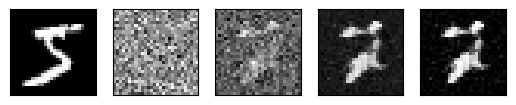

In [450]:
# generate samples from the model
# from prior_utils import p_sample_loop
from image_utils import p_sample_loop_large
model.eval()
shape = (1, description['num_ambient_dims'])
sample_image = mnist_train[0][0][0]

start=1e-4
end=6e-2

x_seq = p_sample_loop_large(model, shape, description['num_steps'], device=device, init_x=None, schedule='sigmoid', start=start, end=end)
x_100 = x_seq[0].reshape(28, 28).detach().cpu().numpy()
x_50 = x_seq[80].reshape(28, 28).detach().cpu().numpy()
x_0 = x_seq[-1].reshape(28, 28).detach().cpu().numpy()

from image_utils import unscale_to_zero_to_one
x_100 = unscale_to_zero_to_one(x_100)
x_50 = unscale_to_zero_to_one(x_50)
x_0 = unscale_to_zero_to_one(x_0)

print(sample_image.min().item(), sample_image.max().item())
print(x_100.min(), x_100.max())
print(x_50.min(), x_50.max())
print(x_0.min(), x_0.max())

fig, ax = plt.subplots(1,5)
ax[0].imshow(sample_image, cmap='gray')
ax[1].imshow(x_100, cmap='gray')
ax[2].imshow(x_50, cmap='gray')
ax[3].imshow(x_0, cmap='gray')
ax[4].imshow(x_0, cmap='gray', vmin=0, vmax=1)
from utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

(10, 28, 28)


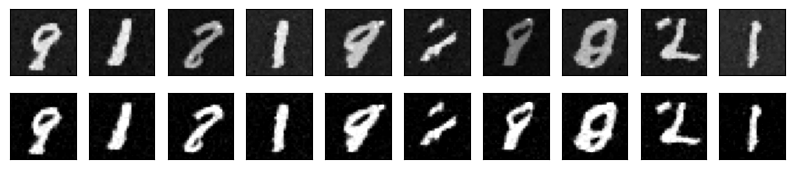

In [515]:
# generate multiple samples
num_samples = 10
shape = (num_samples, description['num_ambient_dims'])
sample_image = mnist_train[0][0][0]

start=2e-7
end=12e-2

x_seq = p_sample_loop_large(model, shape, 150, device=device, init_x=None, schedule='sigmoid', start=start, end=end)
x_0 = x_seq[-1].reshape(num_samples, 28, 28).detach().cpu().numpy()

x_0 = unscale_to_zero_to_one(x_0)
print(x_0.shape)

fig, ax = plt.subplots(2,num_samples, figsize=(num_samples, 2))
for a in range(num_samples):
    ax[0, a].imshow(x_0[a], cmap='gray')
    ax[1, a].imshow(x_0[a], cmap='gray', vmin=0, vmax=1)
    remove_all_ticks_and_labels(ax[:, a])

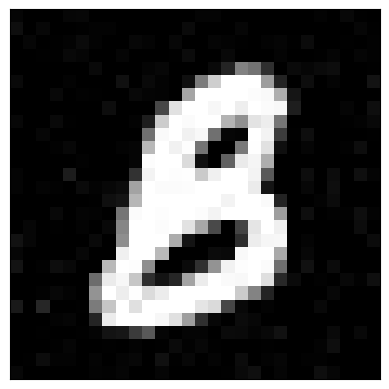

In [294]:
v = 9
fig, ax = plt.subplots(1,1)
ax.imshow(x_0[6], cmap='gray', vmin=0, vmax=1)
remove_all_ticks_and_labels(ax)

# save image
save_dir = os.path.join(base_dir, 'core', 'plots', 'mnist')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save as pdf
fig.savefig(os.path.join(save_dir, f'{description["model_name"]}_{description["model_number"]}_sample{v}.pdf'), dpi=300, bbox_inches='tight')

In [220]:
all_pixels = []
for i in range(100):
    all_pixels.append(mnist_train[i][0].squeeze().reshape(-1))
all_pixels = torch.stack(all_pixels)
print(all_pixels.shape)
from image_utils import rescale_to_neg_one_to_one
all_pixels = rescale_to_neg_one_to_one(all_pixels)
all_pixels = all_pixels.reshape(-1)
print(all_pixels.shape)


print('generating samples from the model')
shape = (100, description['num_ambient_dims'])
x_seq_100s = []
x_seq_50s = []
x_seq_0s = []
x_seq = p_sample_loop_large(model, shape, description['num_steps'], device=device, init_x=None, schedule='sine', start=start, end=end).detach().cpu()
print(x_seq.shape)
x_seq_100s.append(x_seq[0].reshape(-1))
x_seq_50s.append(x_seq[50].reshape(-1))
x_seq_0s.append(x_seq[-1].reshape(-1))
x_seq_100s = torch.stack(x_seq_100s).squeeze()
x_seq_50s = torch.stack(x_seq_50s).squeeze()
x_seq_0s = torch.stack(x_seq_0s).squeeze()

print(x_seq_100s.shape)


torch.Size([100, 784])
torch.Size([78400])
generating samples from the model
torch.Size([151, 100, 784])
torch.Size([78400])


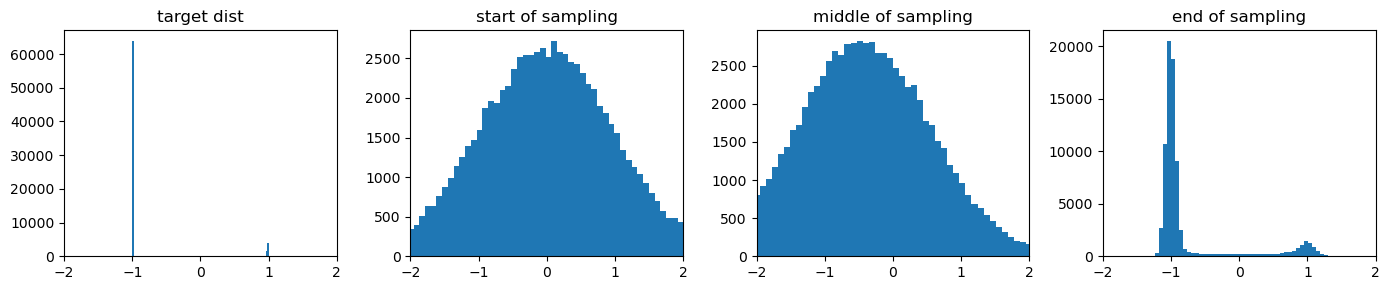

In [221]:
fig, ax = plt.subplots(1,4, figsize=(14, 3), sharex=True)
a = ax[0].hist(all_pixels, bins=100)
ax[0].set(title='target dist')
a = ax[1].hist(x_seq_100s, bins=100)
ax[1].set(title='start of sampling')
a = ax[2].hist(x_seq_50s, bins=100)
ax[2].set(title='middle of sampling')
a = ax[3].hist(x_seq_0s, bins=100)
ax[3].set(title='end of sampling')
for a in ax:
    # a.set_yscale('log')
    # a.set_ylim(1e-1, 6e4)
    a.set_xlim(-2, 2)
fig.tight_layout()

torch.Size([28, 28])


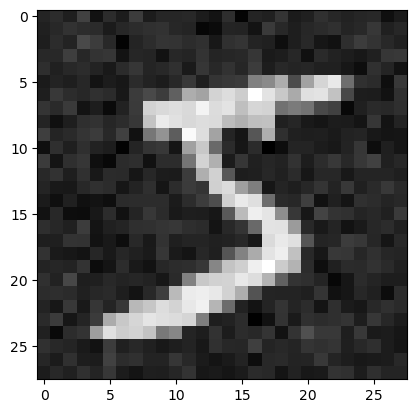

In [107]:
from image_utils import calculate_coefficients
from utils import extract

x0_data = mnist_train[0][0][0].to(device)

_, _, _, _, alphas_bar_sqrt, _, one_minus_alphas_bar_sqrt = calculate_coefficients(100, device, 'sigmoid', start=1e-5, end=2e-2)
t = torch.tensor([20], device=device).long()
t = t.repeat(x0_data.shape[0],).T

# t = torch.randint(99, 100, size=(1,), device=device).long()

# x0 multiplier
a = extract(alphas_bar_sqrt, t, x0_data)

# eps multiplier
am1 = extract(one_minus_alphas_bar_sqrt, t, x0_data)
e = torch.randn_like(x0_data, device=device)

# model input
x = x0_data * a + e * am1

print(x.shape)
fig, ax = plt.subplots(1, 1)
ax.imshow(x.detach().cpu().numpy(), cmap='gray')

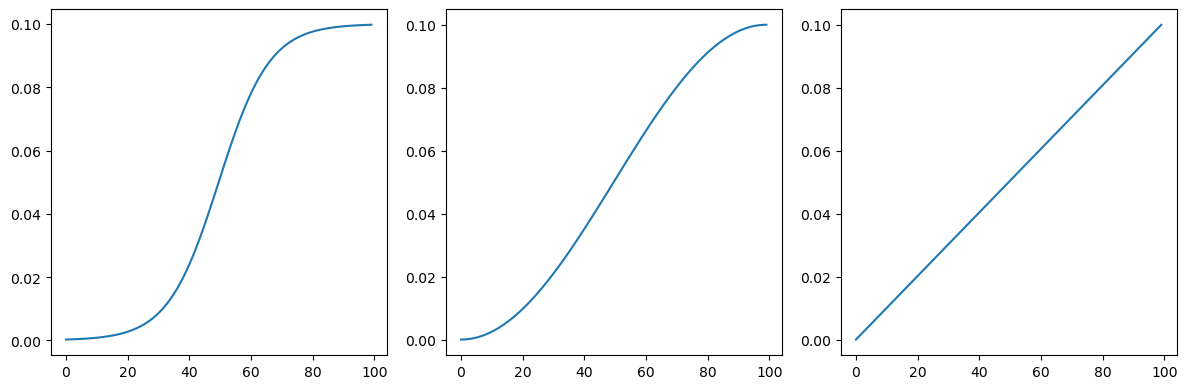

In [111]:
from image_utils import beta_schedule

sig = beta_schedule(schedule='sigmoid', n_timesteps=100)
sin = beta_schedule(schedule='sine', n_timesteps=100)
lin = beta_schedule(schedule='linear', n_timesteps=100)

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].plot(sig)
ax[1].plot(sin)
ax[2].plot(lin)
fig.tight_layout()

All the images look the same... maybe it's not taking the time input into consideration at all?? 

Let's check by looking at the weight corresponding to the input. 

# train MNIST classifier

train a simple feedforward classifier on images from the MNIST dataset and their noisy counterparts

In [4]:
from models import Net

description = {
    'model_name': 'large-noisy-image-classifier',
    'model_num': 3,
    'num_hidden': 32,
    'dataset': 'mnist',
    'num_epochs': 10,
    'lr': 4e-3,
    'num_steps': 150,
    'batch_size': 512,
    'num_in': 28*28,
    'schedule': 'sigmoid',
    'start': 1e-7,
    'end': 1e-1,
}
# save description
with open(os.path.join(base_dir, 'core', 'model_description', f'{description["model_name"]}_{description["model_num"]}.json'), 'w') as f:
    json.dump(description, f)

classifier = Net(norm_method='nn', num_channels=description['num_hidden'], num_steps=description['num_steps'])

In [5]:
classifier

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu): ReLU()
  (conv_2): Conv2d(32, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=500, out_features=10, bias=True)
  (norm_1): Normalization()
  (norm_2): Normalization()
  (embed): Embedding(150, 32)
)

In [6]:
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')

mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,))
                ]))

# mnist_train.targets
print(mnist_train[0][1])

# ------------------------------- select digits ------------------------------ #
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

5


In [1]:
# training 
from image_utils import generate_many_noisy_samples, rescale_to_neg_one_to_one
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

def classifier_loss(model, x, labels, num_classes, num_steps, schedule, start, end):
    '''
    Calculates the loss associated with the model's prediction of the data. 
    This fn is given a batch of data with associated labels. 
    '''
    batch_size = x.shape[0]
    # x = x.reshape(batch_size, -1)
    x = rescale_to_neg_one_to_one(x)
    
    # add noise to the data
    t = torch.randint(0, num_steps, size=(batch_size,), device=device).long()
    # x_noisy = generate_many_noisy_samples(num_steps, x, t, schedule, start, end, device).reshape(batch_size, -1)
    x_noisy = generate_many_noisy_samples(num_steps, x, t, schedule, start, end, device)
    print(x_noisy.shape)
    
    output = model(x_noisy, t)  # the output is from a softmax, so it produces a probability of each discrete class
    c = torch.nn.functional.one_hot(labels, num_classes).to(torch.float)  # encodes the classes with a one hot encoding
    
    # loss = (c - output).square().mean()
    loss = torch.nn.functional.cross_entropy(output, c)
    return loss


classifier.to(device)
classifier.train()
num_epochs = int(description['num_epochs'])

optimizer = optim.Adam(classifier.parameters(), lr=description['lr'])

run_dir = os.path.join(base_dir, 'demos/runs', f'{description["model_name"]}_{description["model_num"]}')
tb = SummaryWriter(run_dir, flush_secs=1)

for epoch in tqdm(range(1, int(num_epochs) + 1), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/100, maxinterval=float("inf")):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        loss = classifier_loss(classifier, data, target, 10, description['num_steps'], description['schedule'], description['start'], description['end'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tb.add_scalar('Loss', loss.item(), epoch+batch_idx)

print('training is over at last')

# save model weights
from utils import save_model_weights
save_model_weights(classifier, description['model_name'], description['model_num'])
tb.flush()

ModuleNotFoundError: No module named 'image_utils'

In [623]:
# test the model performance
from utils import load_model_weights
from image_utils import generate_many_noisy_samples
model_name = 'large-noisy-image-classifier'
model_num = 3

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{model_name}_{model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    description = json.load(f)

# load model weights
load_model = True

if load_model == True:
    from models import LargeNoisyImageClassifier, Net
    # model = LargeNoisyImageClassifier(num_in=description['num_in'], num_hidden=description['num_hidden'], num_classes=10, num_steps=description['num_steps'])
    model = Net(norm_method='nn', num_channels=description['num_hidden'])
    model = model.to(device)
    from utils import load_model_weights
    model_name = f"{description['model_name']}_{description['model_num']}.pt"
    loadpath = os.path.join(base_dir, f'core/saved_weights', model_name)
    state_dict = torch.load(loadpath, map_location=device)
    # model = load_model_weights(model, description['model_name'], description['model_num'], device)
    # model = model.to(device)
    model.eval()
    
# load data
def test_classifier_accuracy(model, num_test_samples,):
    import torch
    from torchvision import datasets, transforms
    mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')
    mnist_test = datasets.MNIST(mnist_dir, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]))

    test_loader = torch.utils.data.DataLoader(
        mnist_test,
        batch_size=num_test_samples, shuffle=True)

    # test the model
    from image_utils import get_classifier_acc

    for batch_idx, (test_data, test_targets) in enumerate(test_loader):
        test_data = test_data.to(device).reshape(-1, 28*28)
        # add noise to image
        
        test_targets = test_targets.to(device)
        acc = get_classifier_acc(model, test_data, test_targets)
        print(acc)
        break

test_classifier_accuracy(model, 100)

Using device: cuda


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 784]